In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.utils import shuffle
from wordcloud import WordCloud
%matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Activation,Lambda,Input,Embedding,LSTM

In [4]:
df=pd.read_csv('/content/hindi_english_parallel.csv')
print(df.head())

                                               hindi  \
0    अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें   
1                    एक्सेर्साइसर पहुंचनीयता अन्वेषक   
2              निचले पटल के लिए डिफोल्ट प्लग-इन खाका   
3               ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका   
4  उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...   

                                          english  
0  Give your application an accessibility workout  
1               Accerciser Accessibility Explorer  
2  The default plugin layout for the bottom panel  
3     The default plugin layout for the top panel  
4  A list of plugins that are disabled by default  


In [5]:
print(len(df))

1561841


In [6]:
# Checking for Null values
df.isnull().sum()

,0
hindi,6057
english,877


In [7]:
# Dropping null values and resetting the index
df.dropna(inplace=True)
df=df.reset_index(drop=True)

In [8]:

df.isnull().sum()

,0
hindi,0
english,0


In [9]:
len(df)

1555574

In [10]:
df['english']

,english
0,Give your application an accessibility workout
1,Accerciser Accessibility Explorer
2,The default plugin layout for the bottom panel
3,The default plugin layout for the top panel
4,A list of plugins that are disabled by default
...,...
1555569,शपथ लेने/प्रतिज्ञान करने वाले सदस्य
1555570,स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...
1555571,है। I note that this is a landmark meeting – n...
1555572,है। In the presentations that they made before...


In [11]:
# There are some rows in english columns that contains hindi
df.iloc[155570]

,155570
hindi,"% 1 ने चैनल विषय को ""% 2"" पर सेट किया."
english,% 1 sets the channel mode '% 2'.


In [12]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


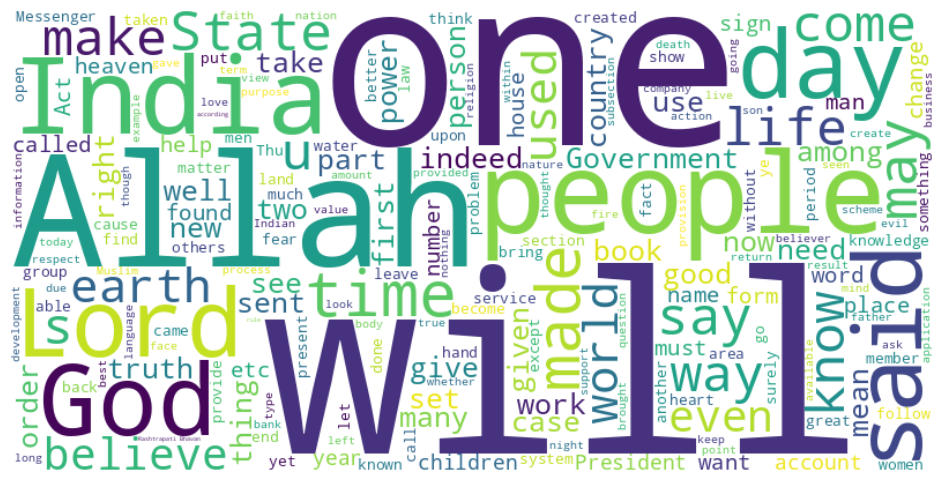

In [13]:
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Make sure to use the correct column name for English
corpus_list = []
for line in df['english']:   # change 'english' to your actual column name
    cleaned_line = re.sub(r'[^A-Za-z\s]', '', str(line))  # keep only English letters
    cleaned_line = ' '.join(cleaned_line.split())          # remove extra spaces
    corpus_list.append(cleaned_line)

corpus = ' '.join(corpus_list)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

plt.figure(figsize=(13,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [14]:
# Removing the rows that contains hindi sentences as it will just create noise in the dataset
def contains_Hindi(text):
    if isinstance(text,str):
        return bool(re.search(r'[\u0900-\u097F]',text))
    return False
df_filtered=df[~df['english'].apply(contains_Hindi)].reset_index(drop=True)

In [15]:
Embedding_dim=100
Latent_dim=400
max_seq_len=100
max_vocab_size=30000

In [16]:
# As the data size is large we will work with 20000 sentences
input_text=[]
target_text=[]
target_text_input=[]
translation=[]
i=19999
for j,t in enumerate(df['english']):
    input_text.append(t)
    if j==i:
        j=0
        break
for j,t in enumerate(df['hindi']):
    translation.append(t)
    target_text.append(t+' <eos>')
    target_text_input.append('<sos> '+t)
    if j==i:
        break

In [17]:
#Input
tokenizer_input=Tokenizer(num_words=max_vocab_size)
tokenizer_input.fit_on_texts(input_text)
tokenized_input=tokenizer_input.texts_to_sequences(input_text)

In [18]:
word2idx=tokenizer_input.word_index
print('word2idx length:',len(word2idx))

word2idx length: 2036


In [19]:
#Output
tokenizer_output=Tokenizer(num_words=max_vocab_size,filters='')
tokenizer_output.fit_on_texts(target_text_input+target_text)
tokenized_target=tokenizer_output.texts_to_sequences(target_text)              #target output
tokenized_target_input=tokenizer_output.texts_to_sequences(target_text_input)  #teacher forcing

In [20]:
word2idx_output=tokenizer_output.word_index
print('length of word2idx output:',len(word2idx_output))
num_words_output=len(word2idx_output)+1

length of word2idx output: 2936


In [21]:
import zipfile

# Extract the zip
with zipfile.ZipFile("/content/glove.6B.100d.txt.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Now read the extracted file
word_vec = {}
with open("/content/glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        word_vec[word] = vector

print('length of word vector =', len(word_vec))



length of word vector = 400000


In [22]:
#Input
encoder_input=pad_sequences(tokenized_input,maxlen=max_seq_len)
print('Encoder input shape=',encoder_input.shape)

Encoder input shape= (20000, 100)


In [23]:
#target output as input for teacher forcing
decoder_input=pad_sequences(tokenized_target_input,maxlen=max_seq_len,padding='post')
print('decoder input shape:',decoder_input.shape)

decoder input shape: (20000, 100)


In [24]:
#target output
decoder_output=pad_sequences(tokenized_target,maxlen=max_seq_len,padding='post')
print('decoder output shape:',decoder_output.shape)

decoder output shape: (20000, 100)


In [25]:
#creating count matrix
num_words=min(max_vocab_size,len(word2idx)+1)
word_embedding=np.zeros((num_words,Embedding_dim))
for word,i in word2idx.items():
    if i<max_vocab_size:
        vec=word_vec.get(word)
        if vec is not None:
            word_embedding[i]=vec
print('shape of word_embedding:',word_embedding.shape)

shape of word_embedding: (2037, 100)


In [26]:
embedding_layer_input=Embedding(num_words,
                          Embedding_dim,
                          weights=[word_embedding],
                          trainable=True)

In [27]:
#Encoder
encoder_input_placeholder=Input(shape=(max_seq_len,))
x=embedding_layer_input(encoder_input_placeholder)
encoder_lstm=LSTM(Latent_dim,return_state=True)
encoder_output,h,c=encoder_lstm(x)
encoder_states=[h,c]

In [28]:
#Decoder
decoder_input_placeholder=Input(shape=(max_seq_len,))
decoder_embedding=Embedding(num_words_output,Embedding_dim)
x=decoder_embedding(decoder_input_placeholder)
decoder_lstm=LSTM(Latent_dim,return_state=True,return_sequences=True)
decoder_outputs,_,_=decoder_lstm(x,initial_state=encoder_states)
decoder_dense=Dense(num_words_output,activation='softmax')
decoder_outputs=decoder_dense(decoder_outputs)

In [29]:
model=Model([encoder_input_placeholder,decoder_input_placeholder],      # Teacher Forcing
            decoder_outputs)

In [30]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
hist=model.fit([encoder_input,decoder_input],
               decoder_output,
               epochs=150,
               validation_split=0.2,
               batch_size=32)

Epoch 1/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.9462 - loss: 0.7212 - val_accuracy: 0.9683 - val_loss: 0.2020
Epoch 2/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9658 - loss: 0.2060 - val_accuracy: 0.9720 - val_loss: 0.1603
Epoch 3/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9736 - loss: 0.1434 - val_accuracy: 0.9782 - val_loss: 0.1092
Epoch 4/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.9808 - loss: 0.0943 - val_accuracy: 0.9846 - val_loss: 0.0700
Epoch 5/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9876 - loss: 0.0595 - val_accuracy: 0.9883 - val_loss: 0.0493
Epoch 6/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.9913 - loss: 0.0404 - val_accuracy: 0.9925 - val_loss: 0.0330
Epoch 7/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.9939 - loss: 0.0277 - val_accuracy: 0.9948 - val_loss: 0.0240
Epoch 8/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9955 - loss: 0

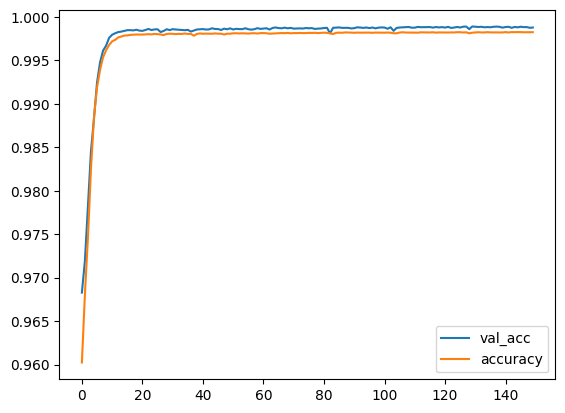

In [32]:
plt.plot(hist.history['val_accuracy'],label='val_acc')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.legend()

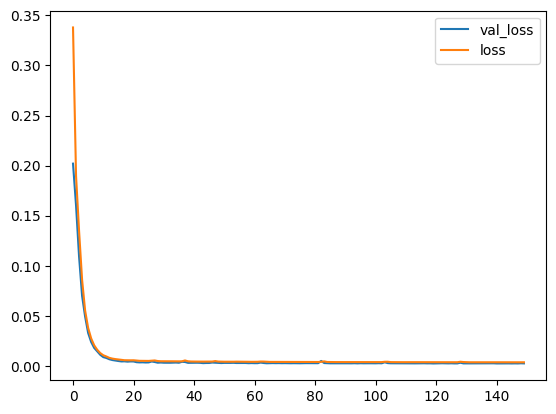

In [33]:
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['loss'],label='loss')
plt.legend()

In [34]:
encoder_model=Model(encoder_input_placeholder,encoder_states)

In [35]:
# Decoder for prediction (one input at a time)
decoder_inital_h=Input(shape=(Latent_dim,))
decoder_inital_c=Input(shape=(Latent_dim,))

decoder_initial_states=[decoder_inital_h,decoder_inital_c]

decoder_input_single=Input(shape=(1,))
decoder_embedding_single=decoder_embedding(decoder_input_single)
decoder_outputs_x,h,c=decoder_lstm(decoder_embedding_single,initial_state=decoder_initial_states)

decoder_states=[h,c]

decoder_output=decoder_dense(decoder_outputs_x)

decoder_model=Model([decoder_input_single]  +  decoder_initial_states,
                    [decoder_output]  +  decoder_states
                   )

In [36]:
idx2word_output={v:k for k,v in word2idx_output.items()}

In [37]:
def decode_sequence(sequence):
    states_value=encoder_model.predict(sequence,verbose=0)     # context vector:-will return [h,c]

    target_seq=np.zeros((1,1))
    target_seq[0,0]=word2idx_output['<sos>']    #First input to decoder

    eos=word2idx_output['<eos>']

    output_sequence=[]

    for _ in range(max_seq_len):
        output_token,h,c=decoder_model.predict([target_seq]+states_value,verbose=0)

        idx=np.argmax(output_token[0,0,:])

        if idx==eos:                       # if the predicted token is <eos>
            break

        if idx>0:
            output_sequence.append(idx2word_output[idx])

        target_seq[0,0]=idx

        states_value=[h,c]

    return ' '.join(output_sequence)

In [38]:
i=0
while i<10:
    j=np.random.choice(len(encoder_input))
    input_seq=encoder_input[j:j+1]
    seq=decode_sequence(input_seq)
    print('------------------')
    print('input text:',input_text[j])
    print('real output',translation[j])
    print('predicted output:',seq)
    i+=1

------------------
input text: Are you sure you want to remove the following elements from the project?
real output को मिटाएँ अनुसरण कर रहा है से नहीं नहीं
predicted output: को मिटाएँ अनुसरण कर रहा है से नहीं नहीं
------------------
input text: _ Context Help
real output संदर्भ मदद (_ C) 
predicted output: संदर्भ मदद (_ c)
------------------
input text: ten of hearts
real output लाल पान का दहला
predicted output: लाल पान का दहला
------------------
input text: Please enter a branch / tag URL.
real output कृपया एंटर a URL. 
predicted output: कृपया एंटर a url.
------------------
input text: Project Loaded
real output परियोजना लोड किया
predicted output: परियोजना लोड किया
------------------
input text: Profiling
real output प्रोफाइलिंग
predicted output: प्रोफाइलिंग
------------------
input text: % s on tableau
real output % s झांकी परwasteslot hint
predicted output: % s झांकी परwasteslot hint
------------------
input text: A generic Xlib dock applet
real output जेनेरिक Xlib डाक एप्लेट
predic

In [44]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import re

# Smoothing (important for short sentences)
smooth = SmoothingFunction().method5

def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r"[^\w\s]", "", text)
    return text

# Number of samples to evaluate
num_samples = 50

# Randomly select samples
sample_indices = np.random.choice(len(encoder_input), num_samples, replace=False)

bleu_scores = []

for idx in sample_indices:
    input_seq = encoder_input[idx:idx+1]
    pred = decode_sequence(input_seq)
    ref = translation[idx]

    ref_clean = clean_text(ref)
    pred_clean = clean_text(pred)

    # skip empty predictions
    if len(pred_clean.split()) == 0:
        continue

    bleu = sentence_bleu(
        [ref_clean.split()],
        pred_clean.split(),
        weights=(0.5, 0.5, 0, 0),   # best for short phrases
        smoothing_function=smooth
    )

    bleu_scores.append(bleu)

avg_bleu = np.mean(bleu_scores)
print(f"Average Sentence BLEU: {avg_bleu:.4f}")


Average Sentence BLEU: 0.8715
